In [35]:
# Clone the repo to access Data/, code/, etc.
!git clone https://github.com/mr-kelsey/su25-aai511-group6.git
%cd su25-aai511-group6
import os
print("Working directory:", os.getcwd())



Cloning into 'su25-aai511-group6'...
remote: Enumerating objects: 3231, done.
remote: Counting objects: 100% (3231/3231), done.
remote: Compressing objects: 100% (3157/3157), done.
remote: Total 3231 (delta 90), reused 3190 (delta 66), pack-reused 0 (from 0)
Receiving objects: 100% (3231/3231), 26.22 MiB | 29.74 MiB/s, done.
Resolving deltas: 100% (90/90), done.
/content/su25-aai511-group6/su25-aai511-group6/su25-aai511-group6
Working directory: /content/su25-aai511-group6/su25-aai511-group6/su25-aai511-group6


In [36]:
!ls /content


Data  sample_data  su25-aai511-group6


In [37]:
from pathlib import Path

DATA_PATH = Path("Data")
AUG_PATH = DATA_PATH / "Augmented"
midi_paths = list(AUG_PATH.glob("**/*.mid"))
print(f"✅ Found {len(midi_paths)} MIDI files")


✅ Found 400 MIDI files


In [38]:
!pip install miditok


In [39]:
!pip install miditok miditoolkit torchmetrics matplotlib tqdm ipywidgets


In [72]:
"""Imports"""
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from miditok import REMI, TokenizerConfig
from miditok.pytorch_data import DatasetMIDI, DataCollator
from miditok.utils import split_files_for_training
from pathlib import Path
from random import shuffle, seed as random_seed
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
from torchmetrics.classification import MulticlassConfusionMatrix

In [73]:
"""Set seeds and device"""
random_seed(73)
np.random.seed(73)
torch.manual_seed(73)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(73)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Prepare Data for LSTM architecture

In [74]:
"""Train new tokenizer based on all augmented data"""
DATA_PATH = Path(Path.cwd().parent, "Data")
midi_paths = list(Path(DATA_PATH, "Augmented").glob(f"**/*.mid"))

config = TokenizerConfig(use_chords=True, use_rests=True, use_tempos=True, use_programs=True, one_token_stream_for_programs=False)
tokenizer = REMI(config)
tokenizer.train(vocab_size=500, files_paths=midi_paths)

tokenizer.is_trained
# NOTE: The vocab_size is a hyperparameter we could play with for optimization

print(tokenizer.is_trained)


True


In [75]:
from miditoolkit import MidiFile

# Filter midi_paths to keep only files that contain notes
def file_has_notes(path):
    try:

        midi = MidiFile(str(path))

        return any(len(track.notes) > 0 for track in midi.instruments)
    except:
        return False

midi_paths = [p for p in midi_paths if file_has_notes(p)]
print(f"✅ {len(midi_paths)} files with notes retained")




✅ 400 files with notes retained


In [76]:
from pathlib import Path

# Recursively get all .mid files from the Augmented folder
midi_paths = list(Path("Data/Augmented").rglob("*.mid"))

print(f"🎵 Found {len(midi_paths)} .mid files")


🎵 Found 400 .mid files


In [77]:
for p in midi_paths[:5]:
    print(p)


Data/Augmented/Beethoven/0012_26#p-6.mid
Data/Augmented/Beethoven/0012_16#d96.mid
Data/Augmented/Beethoven/0012_4#v4.mid
Data/Augmented/Beethoven/0012_39#v-4.mid
Data/Augmented/Beethoven/0012_32#v-4.mid


In [78]:
from miditoolkit import MidiFile

def file_has_notes(path):
    try:
        midi = MidiFile(str(path))
        # Fallback to checking notes even if .instruments is empty
        if midi.instruments:
            return any(len(track.notes) > 0 for track in midi.instruments)
        else:
            return len(midi.notes) > 0  # Fallback for type-0 files
    except Exception as e:
        print(f"❌ Error in {path.name}: {e}")
        return False


In [79]:
filtered_paths = [p for p in midi_paths if file_has_notes(p)]
print(f"✅ {len(filtered_paths)} files with notes retained")



✅ 400 files with notes retained


In [80]:
from pathlib import Path

# using absolute paths to avoid mismatch
midi_paths = list(Path("Data/Augmented").resolve().rglob("*.mid"))
print(f"Number of MIDI files: {len(midi_paths)}")

Number of MIDI files: 400


In [81]:
"""Split into train/valid/test datasets using roughly 15% of the data for each of valid and test"""
total_num_files = len(midi_paths)
num_files_valid = round(total_num_files * 0.05)
num_files_test = round(total_num_files * 0.15)
shuffle(midi_paths)
midi_paths_valid = midi_paths[:num_files_valid]
midi_paths_test = midi_paths[num_files_valid:num_files_valid + num_files_test]
midi_paths_train = midi_paths[num_files_valid + num_files_test:]

for files_paths, subset_name in (
    (midi_paths_train, "Train"), (midi_paths_valid, "Validate"), (midi_paths_test, "Test")
):
    subset_chunks_dir = Path(DATA_PATH, "LSTM", subset_name)
    split_files_for_training(
        files_paths=files_paths,
        tokenizer=tokenizer,
        save_dir=subset_chunks_dir,
        max_seq_len=1024,
        num_overlap_bars=2,
    )

In [82]:
"""Create torch compatable data loaders using the datasets created above"""
#TODO See if we can make padding happen in the dataloader itself instead of needing to pad the data generated by the data loader
class Capture:
	def __init__(self):
		self.score = None
		self.tok_sequence = None

	def lable_composer(self, score, tok_sequence, file_path):
		self.score = score
		self.tok_sequence = tok_sequence
		composer = file_path.parts[-2:-1]
		if "Bach" in composer:
			return 0
		elif "Beethoven" in composer:
			return 1
		elif "Chopin" in composer:
			return 2
		elif "Mozart" in composer:
			return 3
		else:
			return -1

capture = Capture()
collator = DataCollator(tokenizer.pad_token_id)
use_cuda = torch.cuda.is_available()

dataset_train = DatasetMIDI(
    files_paths=list(Path(DATA_PATH, "LSTM", "Train").glob("**/*.mid")),
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
    func_to_get_labels=capture.lable_composer
)
dataloader_train = DataLoader(dataset_train, batch_size=16, collate_fn=collator, shuffle=True, pin_memory=use_cuda)

dataset_valid = DatasetMIDI(
    files_paths=list(Path(DATA_PATH, "LSTM", "Validate").glob("**/*.mid")),
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
	func_to_get_labels=capture.lable_composer
)
dataloader_valid = DataLoader(dataset_valid, batch_size=16, collate_fn=collator, shuffle=True, pin_memory=use_cuda) # increased batch size to 16 for faster training

dataset_test = DatasetMIDI(
    files_paths=list(Path(DATA_PATH, "LSTM", "Test").glob("**/*.mid")),
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
	func_to_get_labels=capture.lable_composer
)
dataloader_test = DataLoader(dataset_test, batch_size=16, collate_fn=collator, pin_memory=use_cuda) #using pin memory to make execution faster in GPU(by speeding up datatrafer from cpu to gpu)

Build Model

In [87]:
# LSTM model definition for sequence prediction


class ComposerLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0):
        super(ComposerLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)

        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
      # x is a PackedSequence
      packed_output, (hn, cn) = self.lstm(x)  # hn: (num_layers*2, batch, hidden_size)

      # Grab the last layer’s forward and backward hidden states
      forward = hn[-2, :, :]  # shape: (batch, hidden_size)
      backward = hn[-1, :, :] # shape: (batch, hidden_size)
      out = torch.cat((forward, backward), dim=1)

      out = self.fc1(out)
      out = self.relu(out)
      out = self.fc2(out)
      return out



Train Model

In [88]:
def train(model, training, validation, lr=0.001):
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    model.train()

    for data in training:
        input_seqs = data["input_ids"]  # List of variable-length tensors
        lengths = torch.tensor([len(seq) for seq in input_seqs], dtype=torch.int64)

        padded_inputs = pad_sequence(input_seqs, batch_first=True, padding_value=tokenizer.pad_token_id).float().to(device)
        padded_inputs = padded_inputs.unsqueeze(-1)  # (batch, seq_len, 1)
        packed_inputs = pack_padded_sequence(padded_inputs, lengths, batch_first=True, enforce_sorted=False)

        #labels = data["labels"].squeeze().long().to(device)  # shape: (batch,) or (batch, num_classes) depending on output
        labels = data["labels"].view(-1).long().to(device)


        optimizer.zero_grad()
        outputs = model(packed_inputs)  # model should support PackedSequence input
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation
    validation_losses = []
    model.eval()
    with torch.no_grad():
        for v_data in validation:
            v_input_seqs = v_data["input_ids"]
            v_lengths = torch.tensor([len(seq) for seq in v_input_seqs], dtype=torch.int64)

            v_padded = pad_sequence(v_input_seqs, batch_first=True, padding_value=tokenizer.pad_token_id).float().to(device)
            v_padded = v_padded.unsqueeze(-1)
            v_packed = pack_padded_sequence(v_padded, v_lengths, batch_first=True, enforce_sorted=False)

            #v_labels = v_data["labels"].to(device).long()
            #v_labels = v_data["labels"].squeeze().long().to(device)
            v_labels = v_data["labels"].view(-1).long().to(device)



            v_output = model(v_packed)
            v_loss = criterion(v_output, v_labels)
            validation_losses.append(v_loss.item())

    return train_losses, validation_losses





# Train LSTM model
# Initialize your model with correct input_size
model = ComposerLSTM(input_size=1, hidden_size=128, num_layers=2, num_classes=4).to(device) ## changing hidden size from 4096 to 512, in second itereation updated num layers-2, hidden -128

epochs = 100
total_train_losses = []
total_validation_losses = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, val_loss = train(model, dataloader_train, dataloader_valid)
    total_train_losses.append(sum(train_loss) / len(train_loss))
    total_validation_losses.append(sum(val_loss) / len(val_loss))

    print(f"Train Loss: {total_train_losses[-1]:.4f}, Val Loss: {total_validation_losses[-1]:.4f}")



Epoch 1/100
Train Loss: 1.0331, Val Loss: 1.0619

Epoch 2/100
Train Loss: 0.7900, Val Loss: 0.6663

Epoch 3/100
Train Loss: nan, Val Loss: 0.7585

Epoch 4/100
Train Loss: 0.5080, Val Loss: 0.4195

Epoch 5/100
Train Loss: nan, Val Loss: 0.4444

Epoch 6/100
Train Loss: nan, Val Loss: 0.3904

Epoch 7/100
Train Loss: nan, Val Loss: 0.2718

Epoch 8/100
Train Loss: 0.3946, Val Loss: 0.4128

Epoch 9/100
Train Loss: 0.3407, Val Loss: 0.2417

Epoch 10/100
Train Loss: 0.2763, Val Loss: 0.2397

Epoch 11/100
Train Loss: 0.2674, Val Loss: 0.2627

Epoch 12/100
Train Loss: 0.2503, Val Loss: 0.2114

Epoch 13/100
Train Loss: nan, Val Loss: 0.2500

Epoch 14/100
Train Loss: nan, Val Loss: 0.2679

Epoch 15/100
Train Loss: 0.2512, Val Loss: 0.6340

Epoch 16/100
Train Loss: 0.2710, Val Loss: 0.1860

Epoch 17/100
Train Loss: 0.2394, Val Loss: 0.2286

Epoch 18/100
Train Loss: 0.2506, Val Loss: 0.2204

Epoch 19/100
Train Loss: nan, Val Loss: 0.1919

Epoch 20/100
Train Loss: nan, Val Loss: 0.2120

Epoch 21/100

Note: LSTM takes a long time to train.  The padding happening inside the loop certainly plays a role but there are likely other issues at play as well.

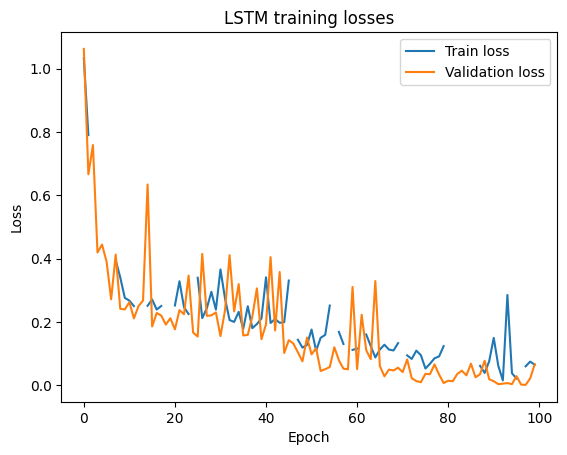

In [89]:
"""Plot training and validation losses"""
# TODO: Not sure why the training and validation quatities are not the same..
plt.title("LSTM training losses")
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.plot(total_train_losses, label="Train loss")
plt.plot(total_validation_losses, label="Validation loss")
plt.legend()
plt.show()

Evaluate Model

In [90]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

prediction = []
truth = []

with torch.no_grad():
    for data in dataloader_test:
        input_seqs = data["input_ids"]
        lengths = torch.tensor([len(seq) for seq in input_seqs], dtype=torch.int64)

        padded_inputs = pad_sequence(input_seqs, batch_first=True, padding_value=tokenizer.pad_token_id).float().to(device)
        padded_inputs = padded_inputs.unsqueeze(-1)

        packed_inputs = pack_padded_sequence(padded_inputs, lengths, batch_first=True, enforce_sorted=False)

        outputs = model(packed_inputs)
        _, predicted = torch.max(outputs.data, 1)

        labels = data["labels"].squeeze().long().to(device)

        prediction.append(predicted.cpu())
        truth.append(labels.cpu())

# Merge batches into a single tensor
prediction = torch.cat(prediction)
truth = torch.cat(truth)


In [91]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(truth, prediction)
print(f"Test Accuracy: {acc:.4f}")


Test Accuracy: 0.8231


In [92]:
"""Create performance metrics"""
accuracy = Accuracy(task="multiclass", num_classes=4)
precision = Precision(task="multiclass", average="macro", num_classes=4)
recall = Recall(task="multiclass", average="macro", num_classes=4)
f1_score = F1Score(task="multiclass", average="macro", num_classes=4)
confusion_matric = ConfusionMatrix(task="multiclass", num_classes=4)

calculated_accuracy = accuracy(truth, prediction)
calculated_precision = precision(truth, prediction)
calculated_recall = recall(truth, prediction)
calculated_f1_score = f1_score(truth, prediction)
calculated_confusion_matric = confusion_matric(truth, prediction)

print("Model Accuracy:", calculated_accuracy)
print("Model Precision:", calculated_precision)
print("Model Recall:", calculated_recall)
print("Model F1:", calculated_f1_score)

Model Accuracy: tensor(0.8231)
Model Precision: tensor(0.7208)
Model Recall: tensor(0.6282)
Model F1: tensor(0.6678)


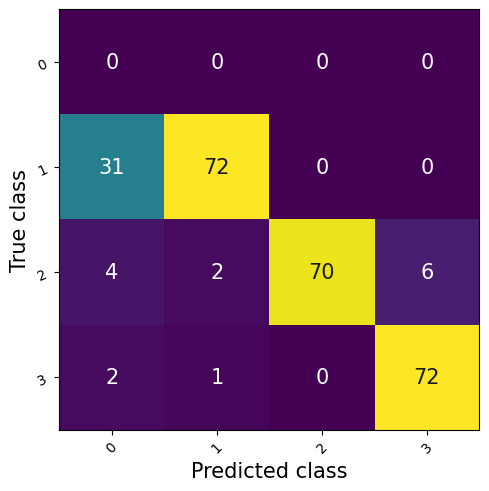

In [93]:
"""Vizulaize confusion matrix"""
metric = MulticlassConfusionMatrix(num_classes=4)
metric.update(truth, prediction)
fig_, ax_ = metric.plot()

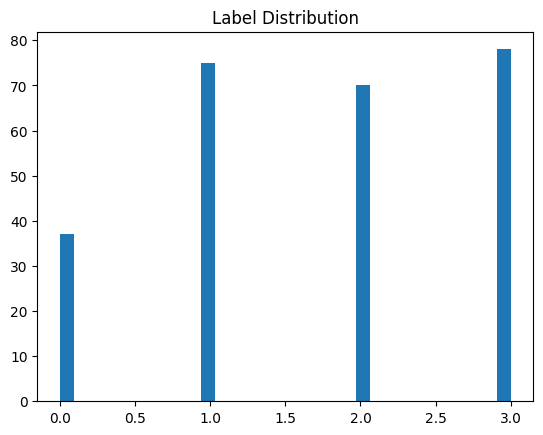

In [94]:
import matplotlib.pyplot as plt
plt.hist(truth.cpu().numpy(), bins=32)
plt.title("Label Distribution")
plt.show()


Optimize hyperparameters

In [ ]:
#TODO: play with the parameters and optimize the CNN architecture